In [1]:
#CS170 HEADER
"""
Chris Buonocore
904587506
Master's Capstone Project
Real Estate Prediction

"""
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
import math
import xgboost as xgb
import gc


from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from scipy import stats
# from skimage import color

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

np.set_printoptions(precision=2) #2 decimal places
np.set_printoptions(suppress=True) #remove scientific notation



"""
module_name, package_name, ClassName, method_name, 
ExceptionName, function_name, GLOBAL_CONSTANT_NAME, 
global_var_name, instance_var_name, function_parameter_name, 
local_var_name

"""

DATA_FOLDER = './redfin'

redfin_train_file = f"{DATA_FOLDER}/redfin_past.csv"
redfin_active_file = f"{DATA_FOLDER}/redfin_active.csv"


    
ZIP_COL = "ZIP OR POSTAL CODE"
STATE_COL = "STATE OR PROVINCE"

MIN_PRICE = 6*10**5
MAX_PRICE = MIN_PRICE*5
print('done')

done


In [149]:
# Redfin Model (using recently sold to predict new house sale prices).

# def edit_nan(x, suffix):
#     if x == 'nan':
#         return x + suffix
#     return x
# def mask(df, f):
#     return df[f(df)]

class RedfinModel:
    DROP_COLS = ['NEXT OPEN HOUSE START TIME', 'FAVORITE', 'INTERESTED', 'SALE TYPE',
                 'NEXT OPEN HOUSE END TIME', 'STATUS', 'SOLD DATE', 'MLS#',
                 'SOURCE', 'ADDRESS', 'LATITUDE','LONGITUDE'] # 'LISTING ID'
    ENCODED_COLS = ['CITY', STATE_COL, 'PROPERTY TYPE', 'LOCATION']
    
    
    def __init__(self):
        # self.train = self.process_train_data(self.data)
        self.X = None
        self.y = None
        self.df = None
        return
    
    def encode_onehot(self, df, cols):
        """
        One-hot encoding is applied to columns specified in a pandas DataFrame.

        Modified from: https://gist.github.com/kljensen/5452382

        Details:

        http://en.wikipedia.org/wiki/One-hot
        http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

        @param df pandas DataFrame
        @param cols a list of columns to encode
        @return a DataFrame with one-hot encoding
        """
        vec = DictVectorizer()

        vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(orient='records')).toarray())
        vec_data.columns = vec.get_feature_names_out()
        vec_data.index = df.index

        df = df.drop(cols, axis=1)
        df = df.join(vec_data)
        self.vec_data_cols = vec_data.columns.values
                     
        return df
    
    
    def process_data(self, data):
        # Warning do not drop rows in this function.
#         data = data[data['SALE TYPE'] == 'PAST SALE']
        data = data.drop(RedfinModel.DROP_COLS, axis=1)
        for c in data.columns.values:
            if 'STATE=' in c or 'LOCATION=' in c or 'URL' in c or 'ZIP' in c:
                data.drop(c, axis=1, inplace=True)
        self.numeric_cols = data.select_dtypes(include = ['float64', 'int64']).columns.values
        data = data.interpolate()
        
        
        undefined_cols_to_zero = ['HOA/MONTH']#['LOT SIZE', 'SQUARE FEET', 'DAYS ON MARKET', '$/SQUARE FEET', 'YEAR BUILT', 'HOA/MONTH']
        for c in undefined_cols_to_zero:
            val = data[c].mean()
            
            if np.isnan(val):
                val = 0
            data[c].fillna(val, inplace=True)
            
        data['CITY'] = data['CITY'].astype(str).apply(lambda x: x.lower())
        data['PROPERTY TYPE'] = data['PROPERTY TYPE'].astype(str).apply(lambda x: x.lower())


        data = self.encode_onehot(data, RedfinModel.ENCODED_COLS)
        print('processed data columns: %s' % data.columns.values)
#         prop_mask = data['PROPERTY TYPE'].str.contains('5') | data['PROPERTY TYPE'].str.contains('vacant')
#         data = data[~prop_mask]


        # location_cols = [x for x in data.columns.values if 'LOCATION' in x]
        # for c in location_cols:
        #     if sum(data[c]) < 2:
        #         data = data.drop(c, axis=1)
                
                
        self.df = data
        return data

    def get_encodings(self, data):
        self.encoders = {}
        for c in RedfinModel.ENCODED_COLS:
            le = LabelEncoder()
            data[c] = data[c].apply(lambda x: x if not pd.isnull(x) else 'Null')
            le.fit(data[c])
            data[c] = le.transform(data[c])
            self.encoders[c] = le
    
    def transform(self, data):
        for c in RedfinModel.ENCODED_COLS:
            data[c] = data[c].apply(lambda x: x if not pd.isnull(x) else 'Null')
            data[c] = self.encoders[c].transform(data[c])
        return data
    
    def inverse_transform(self, data):
        for c in RedfinModel.ENCODED_COLS:
            data[c] = self.encoders[c].inverse_transform(data[c])
        return data
    
    def cat_correlation(self, category, transform_func=None):
        cat = self.df[category]
        if transform_func:
            cat = cat.apply(lambda x: transform_func(x))
        cat_df = pd.get_dummies(cat).join(self.df['PRICE']).astype(int)
        if 'nan' in cat_df.columns.values:
            del cat_df['nan']
        levels =  len(cat_df.columns.values)
        if levels > 60:
            print('%s: too many unique categories %d' % (category, levels))
            return cat_df
        corr = cat_df.corr()
        plt.figure(figsize=(16, 16))
        sns.heatmap(corr, vmax=1, square=True)
        return cat_df
    
    def model_cv_scores(self, d=4, est=250):
        clf = xgb.XGBRegressor(max_depth=d, n_estimators=est)
        clf.fit(self.X,self.y)
        scores = cross_val_score(clf, self.X, self.y, cv=5)
        print(scores, scores.mean())
        return clf
    
    def generate_model_data(self, d=4, est=200):
        full_df = self.df# .dropna() # New, remove null columns
        self.X = full_df.drop('PRICE', axis=1)
        self.y = full_df['PRICE']
        
    def predict_custom(self, data, d=4, est=200):
        # self.model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', HistGradientBoostingRegressor())])
        # self.model = HistGradientBoostingRegressor()
        self.model = xgb.XGBRegressor()

#         self.model = LinearRegression()
        self.model.fit(self.X,self.y)
        # print(self.model.coef_)
        pred = self.model.predict(data)
        return pred
    
    def predict_lin(self, data, d=4, est=200):
        self.model = HistGradientBoostingRegressor()
        self.model.fit(self.X,self.y)
        pred = self.model.predict(data)
        return pred
    
    def predict_xgb(self, data, d=4, est=200):
        self.clf = xgb.XGBRegressor(max_depth=d, n_estimators=est)
        self.clf.fit(self.X,self.y)
        pred = self.clf.predict(data)
        return pred

def convert_int(x):
    try:
        return int(x)
    except:
        return float('nan')

    
def convert_row_to_address(row):
    return "%s %s %s %s - %s, Delta Pred: %s" % (row['ADDRESS'], row['CITY'], row[STATE_COL],
                                   convert_int(row[ZIP_COL]), row['PRICE'], row['Delta Pred'])
def print_rows(data, start, end):
    for i, row in data[start:end].iterrows():
        print(convert_row_to_address(row))


In [150]:
def process_train(data_file):
    t = pd.read_csv(data_file)
    t = t[(t['PRICE'] < MAX_PRICE) 
                  & (t['PRICE'] > MIN_PRICE) 
                  & (t['PROPERTY TYPE'] != 'Vacant Land')]
                  # & ~(t['BEDS'].isnull())
                  #     & ~(t['BATHS'].isnull())
                  #         & ~(t['SQUARE FEET'].isnull())]
                     
    print(t.info())
                 
    return t
    
train = process_train(redfin_train_file)
print(train.columns.values)


np.set_printoptions(precision=2) #2 decimal places
np.set_printoptions(suppress=True) #remove scientific notation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 211
Data columns (total 27 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    75 non-null     object 
 1   SOLD DATE                                                                                    71 non-null     object 
 2   PROPERTY TYPE                                                                                75 non-null     object 
 3   ADDRESS                                                                                      75 non-null     object 
 4   CITY                                                                                         75 non-null     object 
 5   STATE OR PROVINCE                    

In [151]:
set(train['PROPERTY TYPE'])

{'Single Family Residential'}

In [152]:
redfin = RedfinModel()
# print(train.info())
redfin.process_data(train)
redfin.df.info()
df = redfin.df

processed data columns: ['PRICE' 'BEDS' 'BATHS' 'SQUARE FEET' 'LOT SIZE' 'YEAR BUILT'
 'DAYS ON MARKET' '$/SQUARE FEET' 'HOA/MONTH' 'CITY=auburn' 'CITY=bedford'
 'CITY=boscawen' 'CITY=bow' 'CITY=concord' 'CITY=dunbarton'
 'CITY=goffstown' 'CITY=hooksett' 'CITY=hopkinton' 'CITY=londonderry'
 'CITY=manchester' 'CITY=pembroke' 'LOCATION' 'LOCATION=Auburn'
 'LOCATION=Bedford' 'LOCATION=Boscawen' 'LOCATION=Bow' 'LOCATION=Concord'
 'LOCATION=Dunbarton' 'LOCATION=Goffstown' 'LOCATION=Hooksett'
 'LOCATION=Hopkinton' 'LOCATION=Londonderry' 'LOCATION=Manchester'
 'LOCATION=Pembroke' 'PROPERTY TYPE=single family residential'
 'STATE OR PROVINCE=NH']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 211
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PRICE                                    75 non-null     int64  
 1   BEDS                              

<Axes: >

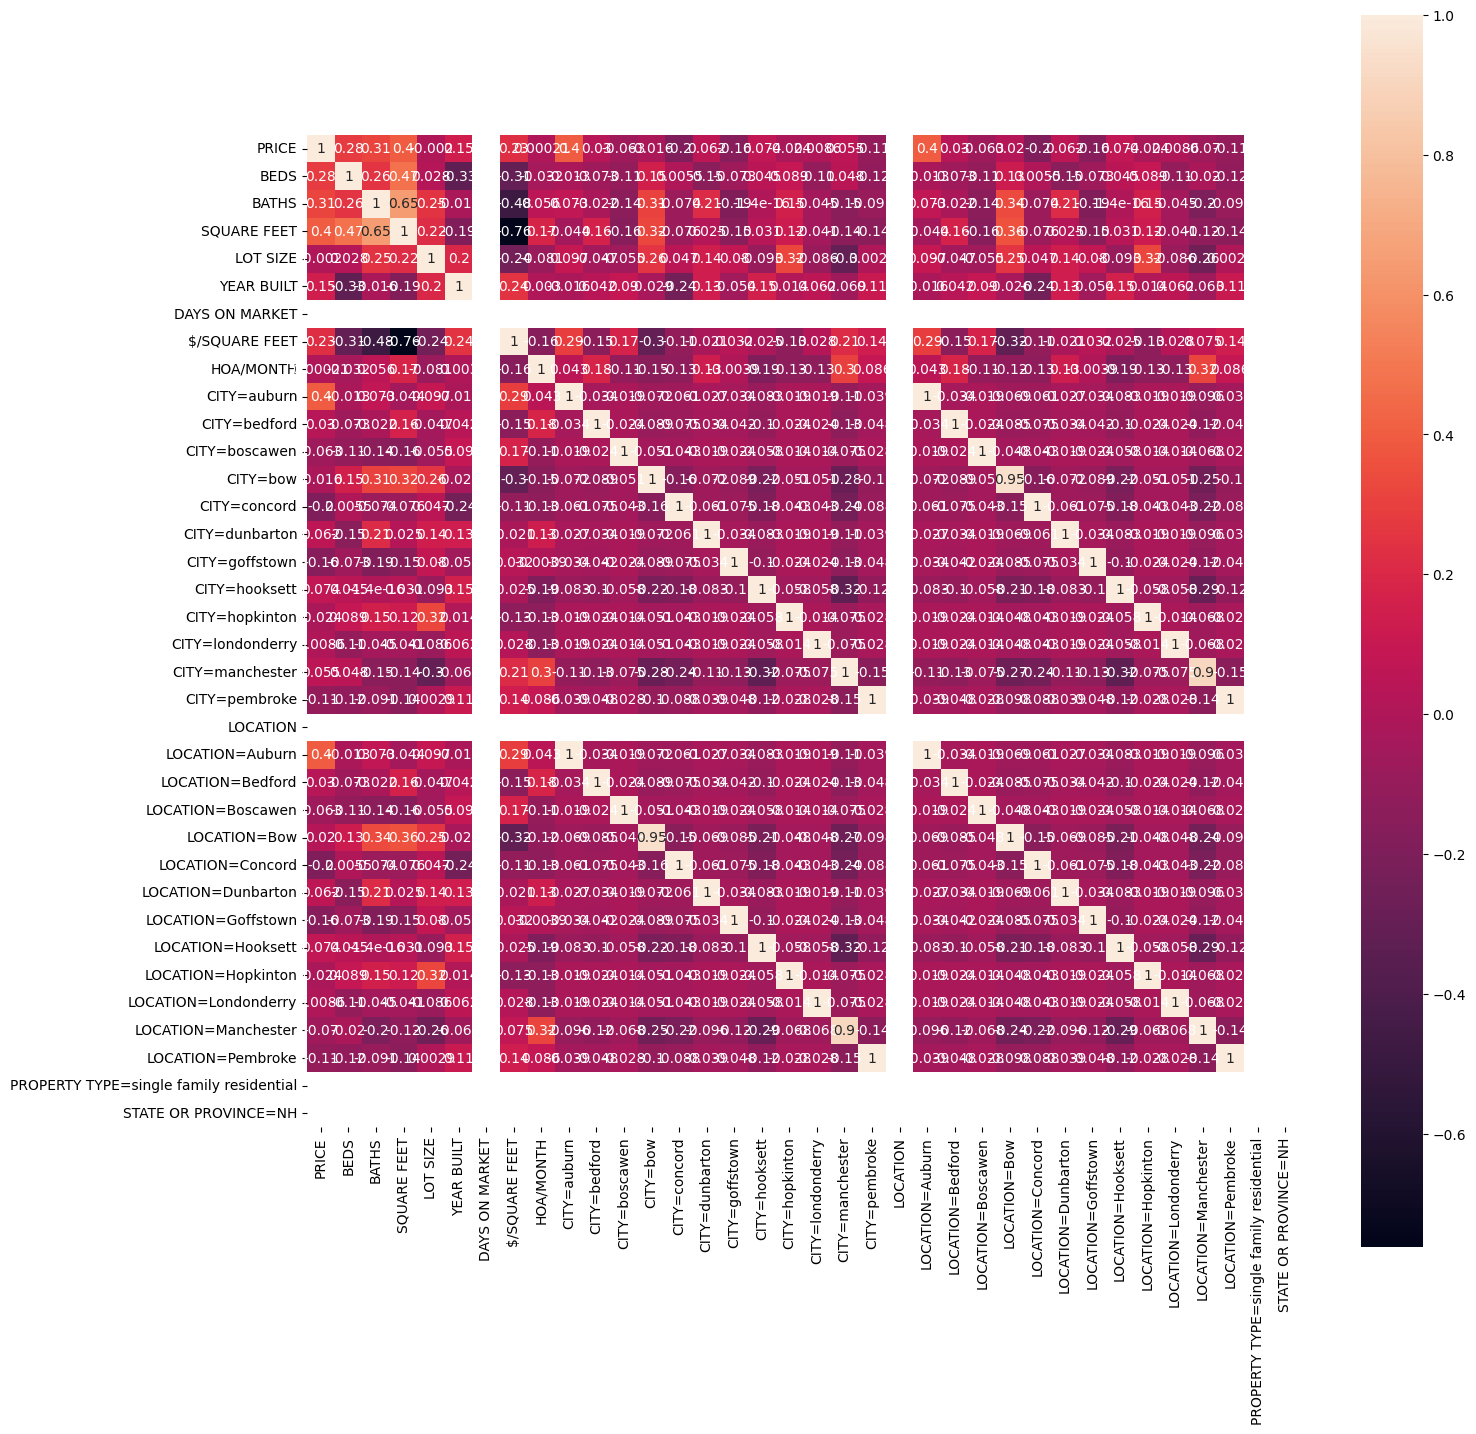

In [153]:
corr = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, vmax=1, square=True, annot=True)

In [154]:
# clf = model_cv_scores(X,y)
redfin.generate_model_data()


In [155]:
# clf = redfin.model_cv_scores()
# print(redfin.X.columns.values)
redfin.X


,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,CITY=auburn,CITY=bedford,...,LOCATION=Concord,LOCATION=Dunbarton,LOCATION=Goffstown,LOCATION=Hooksett,LOCATION=Hopkinton,LOCATION=Londonderry,LOCATION=Manchester,LOCATION=Pembroke,PROPERTY TYPE=single family residential,STATE OR PROVINCE=NH
0,3.00,2.50,"1,752.00","127,630.00","1,971.00",NaN,400.00,106.76,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
1,4.00,2.50,"3,208.00","95,832.00","1,997.00",NaN,214.00,122.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
2,4.00,5.00,"5,373.00","125,888.00","1,998.00",NaN,185.00,106.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
9,3.00,2.50,"2,788.00","33,976.00","2,022.00",NaN,283.00,90.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00
10,4.00,2.50,"2,682.00","22,216.00","2,004.00",NaN,427.00,74.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,3.00,2.50,"1,870.00","22,941.33","2,022.00",NaN,355.00,125.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
202,3.00,2.50,"1,824.00","17,568.67","2,022.00",NaN,351.00,125.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
204,3.00,2.50,"1,871.00","12,196.00","2,022.00",NaN,335.00,15.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00
207,4.00,2.50,"2,100.00","92,347.00","1,996.00",NaN,289.00,15.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00


In [156]:
# redfin.X.dtypes
np.isnan(redfin.X)
print(redfin.X.isnull().any())
# redfin.X = redfin.X.drop('LOCATION', axis=1)
redfin.X.shape

BEDS                                       False
BATHS                                      False
SQUARE FEET                                False
LOT SIZE                                   False
YEAR BUILT                                 False
DAYS ON MARKET                              True
$/SQUARE FEET                              False
HOA/MONTH                                  False
CITY=auburn                                False
CITY=bedford                               False
CITY=boscawen                              False
CITY=bow                                   False
CITY=concord                               False
CITY=dunbarton                             False
CITY=goffstown                             False
CITY=hooksett                              False
CITY=hopkinton                             False
CITY=londonderry                           False
CITY=manchester                            False
CITY=pembroke                              False
LOCATION            

(75, 35)

In [157]:
redfin.X.isnull()
print(redfin.X.iloc[1])

BEDS                                           4.00
BATHS                                          2.50
SQUARE FEET                                3,208.00
LOT SIZE                                  95,832.00
YEAR BUILT                                 1,997.00
DAYS ON MARKET                                  NaN
$/SQUARE FEET                                214.00
HOA/MONTH                                    122.00
CITY=auburn                                    0.00
CITY=bedford                                   1.00
CITY=boscawen                                  0.00
CITY=bow                                       0.00
CITY=concord                                   0.00
CITY=dunbarton                                 0.00
CITY=goffstown                                 0.00
CITY=hooksett                                  0.00
CITY=hopkinton                                 0.00
CITY=londonderry                               0.00
CITY=manchester                                0.00
CITY=pembrok

In [158]:
def print_loc_cols(df):
    cols = [x for x in df.columns.values if 'LOCATION' in x]
    for c in cols:
        print("%40s: %d" % (c, sum(df[c])))
        
# print_loc_cols(redfin.X)

In [159]:
pred = redfin.predict_custom(redfin.X)

/var/folders/08/3gvkyj816j39hpywkn6fwnx80000gq/T/ipykernel_53012/2163796312.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(delta_p,  kde = True, color = 'b', hist_kws={'alpha': 0.9}, norm_hist=False, bins=250)


Mean Price Difference between Prediced and List: 0
count   75.00
mean     0.01
std      0.32
min     -0.75
25%     -0.16
50%      0.00
75%      0.12
max      1.06
Name: PRICE, dtype: float64


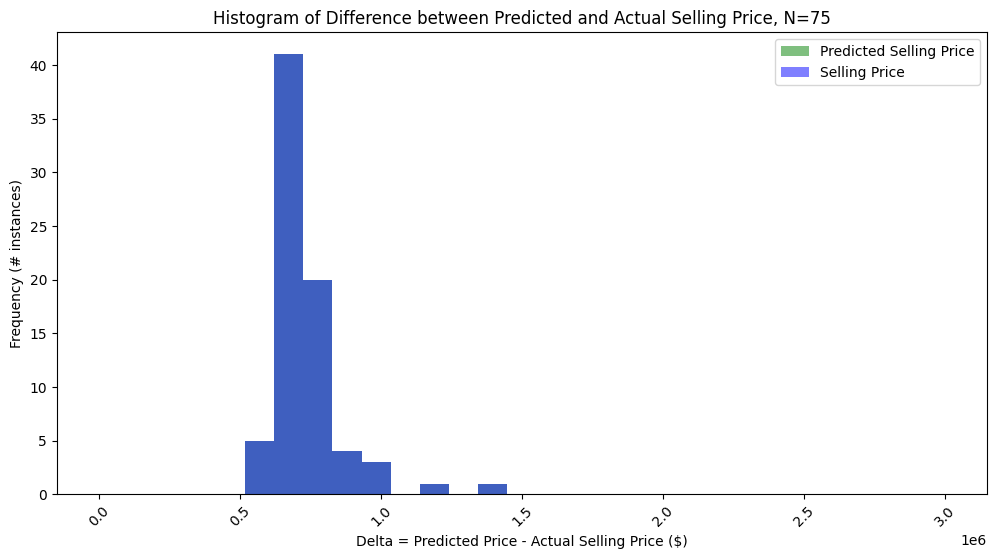

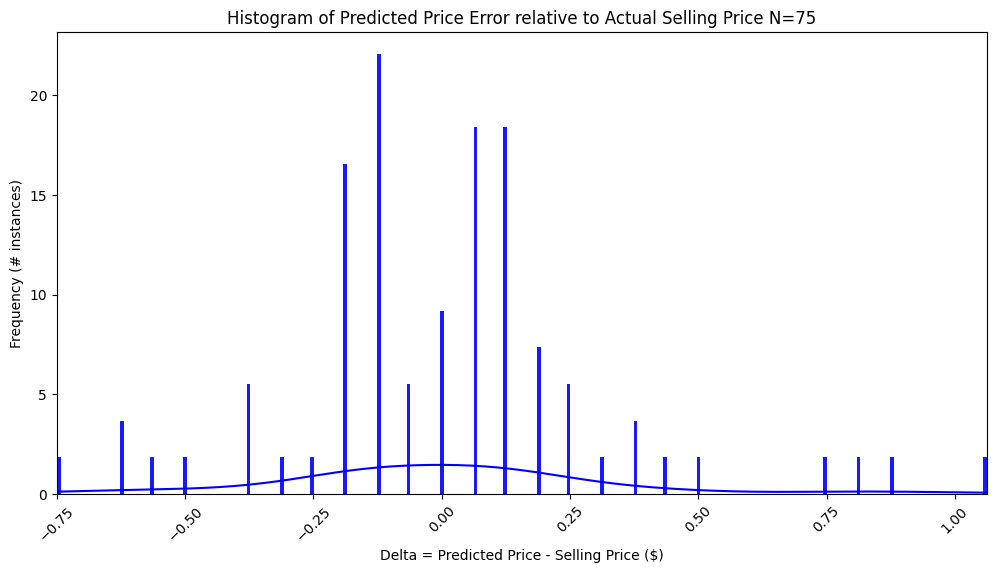

In [160]:


plt.figure(figsize=(12,6))
bins = np.linspace(0, MAX_PRICE, num=30)
plt.hist(pred, bins=bins, label='Predicted Selling Price',edgecolor='None', alpha = 0.5, color= 'g')
plt.hist(redfin.y, bins=bins, label='Selling Price',edgecolor='None', alpha = 0.5, color= 'b')
plt.title("Histogram of Difference between Predicted and Actual Selling Price, N=%d" % len(pred))
plt.xlabel('Delta = Predicted Price - Actual Selling Price ($)')
plt.ylabel('Frequency (# instances)')
plt.legend(loc='upper right')
# plt.xlim(-500, 500)
xt = plt.xticks(rotation=45)

delta_p = pred - redfin.y
delta_p.describe()

plt.figure(figsize = (12, 6))
ax = sns.distplot(delta_p,  kde = True, color = 'b', hist_kws={'alpha': 0.9}, norm_hist=False, bins=250)
ax.set(xlim=(min(delta_p), max(delta_p)))
plt.title("Histogram of Predicted Price Error relative to Actual Selling Price N=%d" % len(delta_p))
plt.xlabel('Delta = Predicted Price - Selling Price ($)')
plt.ylabel('Frequency (# instances)')
xt = plt.xticks(rotation=45)

print("Mean Price Difference between Prediced and List: %d" % delta_p.mean())
print(delta_p.describe())

In [161]:
data = train# redfin.X
data['Delta Pred'] = delta_p

data['Pred Lin'] = pred
sorted_data = data.sort_values(by='Delta Pred', ascending=False)
N = 50

# print_rows(sorted_data, 0, N)
INTEREST_COLS = ['ADDRESS', 'CITY', 'LOT SIZE', 'SQUARE FEET', 'BEDS', 'PRICE']
print(sorted_data.columns.values)

# sorted_data = sorted_data[(sorted_data['PROPERTY TYPE'] != 'condo/co-op')]
sorted_data[:N][INTEREST_COLS]

['SALE TYPE' 'SOLD DATE' 'PROPERTY TYPE' 'ADDRESS' 'CITY'
 'STATE OR PROVINCE' 'ZIP OR POSTAL CODE' 'PRICE' 'BEDS' 'BATHS'
 'LOCATION' 'SQUARE FEET' 'LOT SIZE' 'YEAR BUILT' 'DAYS ON MARKET'
 '$/SQUARE FEET' 'HOA/MONTH' 'STATUS' 'NEXT OPEN HOUSE START TIME'
 'NEXT OPEN HOUSE END TIME'
 'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)'
 'SOURCE' 'MLS#' 'FAVORITE' 'INTERESTED' 'LATITUDE' 'LONGITUDE'
 'Delta Pred' 'Pred Lin']


,ADDRESS,CITY,LOT SIZE,SQUARE FEET,BEDS,PRICE
200,469 Blane Cir #38,Pembroke,NaN,"1,870.00",3.00,663050
172,304 Straw Rd,Manchester,"61,855.00","2,520.00",4.00,715500
76,264 Hackett Hill Rd,Hooksett,"89,734.00","2,875.00",3.00,625000
129,73 Zachary Dr,Dunbarton,"134,600.00","2,880.00",3.00,775000
1,2 CLARK'S Ct,Bedford,"95,832.00","3,208.00",4.00,687500
29,2 Fox Meadow Dr,Bow,"50,529.00","2,480.00",3.00,640000
99,2 Asa Dr,Bow,"127,195.00","2,271.00",4.00,740000
119,78 Arthur Ave Unit 5a,Manchester,"18,735.00","2,415.00",3.00,767385
157,232 Shaker Rd,Concord,"295,336.00","2,568.00",3.00,645000
36,122 Brookview Dr,Hooksett,"28,749.00","3,613.00",4.00,940000


Active Listings 

In [162]:
# active_test_file= './redfin/redfin_boston_active2.csv'
active_data = process_train(redfin_active_file)
active_data.describe()
active_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 1 to 77
Data columns (total 27 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    46 non-null     object 
 1   SOLD DATE                                                                                    0 non-null      float64
 2   PROPERTY TYPE                                                                                46 non-null     object 
 3   ADDRESS                                                                                      46 non-null     object 
 4   CITY                                                                                         46 non-null     object 
 5   STATE OR PROVINCE                     

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
1,MLS Listing,NaN,Single Family Residential,82J Sawmill Rd,Bow,NH,03304,969900,4,3.50,...,Active,NaN,NaN,https://www.redfin.com/NH/Bow/82J-Sawmill-RD-0...,PrimeMLS,4962289,N,Y,43.14,-71.55
2,MLS Listing,NaN,Single Family Residential,53 Curtisville Rd #3,Concord,NH,03301,649900,3,2.00,...,Active,NaN,NaN,https://www.redfin.com/NH/Concord/53-Curtisvil...,PrimeMLS,4962221,N,Y,43.24,-71.51
3,MLS Listing,NaN,Single Family Residential,140 Electric St,Manchester,NH,03102,695000,4,3.00,...,Active,NaN,NaN,https://www.redfin.com/NH/Manchester/140-Elect...,PrimeMLS,4962178,N,Y,43.00,-71.50
6,MLS Listing,NaN,Single Family Residential,82 I Sawmill Rd,Bow,NH,03304,899900,4,2.50,...,Active,NaN,NaN,https://www.redfin.com/NH/Bow/82-I-Sawmill-RD-...,PrimeMLS,4962128,N,Y,43.14,-71.55
7,MLS Listing,NaN,Single Family Residential,135 W RIVER Rd,Hooksett,NH,03106,919000,3,3.00,...,Active,NaN,NaN,https://www.redfin.com/NH/Hooksett/135-West-Ri...,PrimeMLS,4962082,N,Y,43.05,-71.46


In [163]:
red_active = RedfinModel()
red_active.process_data(active_data)
# red_active.X.info()
red_active.generate_model_data()
print(red_active.X.info())
# print(redfin.X.info())


processed data columns: ['PRICE' 'BEDS' 'BATHS' 'SQUARE FEET' 'LOT SIZE' 'YEAR BUILT'
 'DAYS ON MARKET' '$/SQUARE FEET' 'HOA/MONTH' 'CITY=auburn'
 'CITY=boscawen' 'CITY=bow' 'CITY=concord' 'CITY=goffstown'
 'CITY=hooksett' 'CITY=hopkinton' 'CITY=manchester' 'CITY=pembroke'
 'LOCATION=Auburn' 'LOCATION=Boscawen' 'LOCATION=Bow' 'LOCATION=Concord'
 'LOCATION=Goffstown' 'LOCATION=Hooksett' 'LOCATION=Hopkinton'
 'LOCATION=Manchester' 'LOCATION=Pembroke'
 'PROPERTY TYPE=single family residential' 'STATE OR PROVINCE=NH']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 1 to 77
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   BEDS                                     46 non-null     int64  
 1   BATHS                                    46 non-null     float64
 2   SQUARE FEET                              46 non-null     int64  
 3   LOT SIZE              

In [164]:
# OLD

active_cols = set(red_active.X.columns.values)
train_cols = set(redfin.X.columns.values)
print(train_cols)
print("\n===\n")
needed_cols = train_cols - active_cols
extra_cols = active_cols - train_cols
print('test data needs columns: %s' % needed_cols)
print('test data should remove columns: %s' % extra_cols)
if extra_cols:
    red_active.X = red_active.X.drop(extra_cols, axis=1)
if needed_cols:
    red_active.X = red_active.X.reindex(columns=redfin.X.columns.values, fill_value=0)
    
    
# # Match columns if needed
# active_cols = set(red_active.X.columns.values)
# train_cols = set(redfin.X.columns.values)
# needed_cols = train_cols - active_cols
# extra_cols = active_cols - train_cols
# print('test data needs columns: %s' % needed_cols)
# print('test data should remove columns: %s' % extra_cols)
# print('Active, Train: \n%s\n%s' % (active_cols, train_cols))

{'CITY=boscawen', 'CITY=hooksett', 'CITY=dunbarton', '$/SQUARE FEET', 'LOCATION=Auburn', 'PROPERTY TYPE=single family residential', 'CITY=manchester', 'DAYS ON MARKET', 'LOCATION=Pembroke', 'LOCATION', 'BEDS', 'LOCATION=Concord', 'LOCATION=Manchester', 'LOCATION=Londonderry', 'LOCATION=Boscawen', 'CITY=auburn', 'STATE OR PROVINCE=NH', 'LOCATION=Bedford', 'SQUARE FEET', 'CITY=bedford', 'LOT SIZE', 'LOCATION=Goffstown', 'LOCATION=Hopkinton', 'CITY=hopkinton', 'LOCATION=Hooksett', 'CITY=pembroke', 'YEAR BUILT', 'LOCATION=Dunbarton', 'LOCATION=Bow', 'HOA/MONTH', 'CITY=londonderry', 'CITY=goffstown', 'CITY=concord', 'BATHS', 'CITY=bow'}

===

test data needs columns: {'LOCATION', 'LOCATION=Dunbarton', 'CITY=dunbarton', 'CITY=bedford', 'CITY=londonderry', 'LOCATION=Bedford', 'LOCATION=Londonderry'}
test data should remove columns: set()


In [165]:
# red_active.df[:10]
print(red_active.X.info())

red_active.X[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 1 to 77
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   BEDS                                     46 non-null     int64  
 1   BATHS                                    46 non-null     float64
 2   SQUARE FEET                              46 non-null     int64  
 3   LOT SIZE                                 46 non-null     float64
 4   YEAR BUILT                               44 non-null     float64
 5   DAYS ON MARKET                           46 non-null     int64  
 6   $/SQUARE FEET                            46 non-null     int64  
 7   HOA/MONTH                                46 non-null     float64
 8   CITY=auburn                              46 non-null     float64
 9   CITY=bedford                             46 non-null     int64  
 10  CITY=boscawen                            46 non-null

,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,CITY=auburn,CITY=bedford,...,LOCATION=Concord,LOCATION=Dunbarton,LOCATION=Goffstown,LOCATION=Hooksett,LOCATION=Hopkinton,LOCATION=Londonderry,LOCATION=Manchester,LOCATION=Pembroke,PROPERTY TYPE=single family residential,STATE OR PROVINCE=NH
1,4,3.50,3299,"61,855.00",NaN,2,294,105.56,0.00,0,...,0.00,0,0.00,0.00,0.00,0,0.00,0.00,1.00,1.00
2,3,2.00,1744,"88,862.00",NaN,3,373,105.56,0.00,0,...,1.00,0,0.00,0.00,0.00,0,0.00,0.00,1.00,1.00
3,4,3.00,3168,"34,412.00","1,941.00",3,219,105.56,0.00,0,...,0.00,0,0.00,0.00,0.00,0,1.00,0.00,1.00,1.00
6,4,2.50,2820,"73,180.00","1,978.00",3,319,105.56,0.00,0,...,0.00,0,0.00,0.00,0.00,0,0.00,0.00,1.00,1.00
7,3,3.00,4931,"47,916.00","2,015.00",4,186,105.56,0.00,0,...,0.00,0,0.00,1.00,0.00,0,0.00,0.00,1.00,1.00


In [166]:
# red_active.X = red_active.X.dropna()
red_active.X.isnull().any()
# d = red_active.X.interpolate()
# d.isnull().any()

# d.describe()

# set(red_active.X['HOA/MONTH'])

BEDS                                       False
BATHS                                      False
SQUARE FEET                                False
LOT SIZE                                   False
YEAR BUILT                                  True
DAYS ON MARKET                             False
$/SQUARE FEET                              False
HOA/MONTH                                  False
CITY=auburn                                False
CITY=bedford                               False
CITY=boscawen                              False
CITY=bow                                   False
CITY=concord                               False
CITY=dunbarton                             False
CITY=goffstown                             False
CITY=hooksett                              False
CITY=hopkinton                             False
CITY=londonderry                           False
CITY=manchester                            False
CITY=pembroke                              False
LOCATION            

In [167]:
preda_lin = redfin.predict_lin(red_active.X)

In [168]:
preda_custom = redfin.predict_custom(red_active.X)

<class 'xgboost.sklearn.XGBRegressor'>


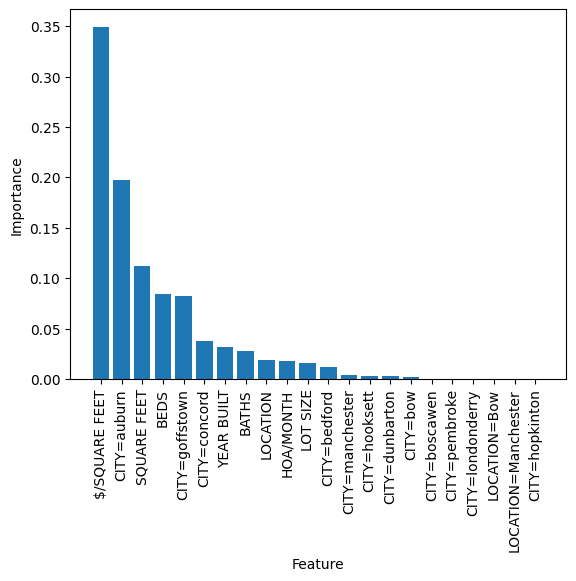

In [204]:


# redfin.feat_imp_dict = redfin.model.get_booster().get_score(importance_type='gain')
# feature_importance = np.asarray([feat_imp_dict.get(i, 0) for i in self.features])

print(redfin.model.__class__)
importances = redfin.model.feature_importances_
zipped_cols = list(zip(redfin.X.columns.values, importances))

res = sorted(zipped_cols, key = lambda x: x[1], reverse=True)
res = [r for r in res if r[1] > 0]

# print(res)

fig, ax = plt.subplots()
idx = range(len(res))
plt.bar(idx, [x[1] for x in res])

plt.xlabel("Feature")
plt.ylabel("Importance")

plt.xticks(idx, [x[0] for x in res], rotation=90)


plt.show()

In [170]:
# print(red_active.X.sum())
# print(len(pred_active))
print_loc_cols(red_active.X)

                                LOCATION: 0
                         LOCATION=Auburn: 2
                        LOCATION=Bedford: 0
                       LOCATION=Boscawen: 4
                            LOCATION=Bow: 13
                        LOCATION=Concord: 10
                      LOCATION=Dunbarton: 0
                      LOCATION=Goffstown: 1
                       LOCATION=Hooksett: 5
                      LOCATION=Hopkinton: 2
                    LOCATION=Londonderry: 0
                     LOCATION=Manchester: 7
                       LOCATION=Pembroke: 2


Note that predicted price is not trying to match the Listing price
The predicted price is meant to be an objective measure of the property's value based on its column characteristics


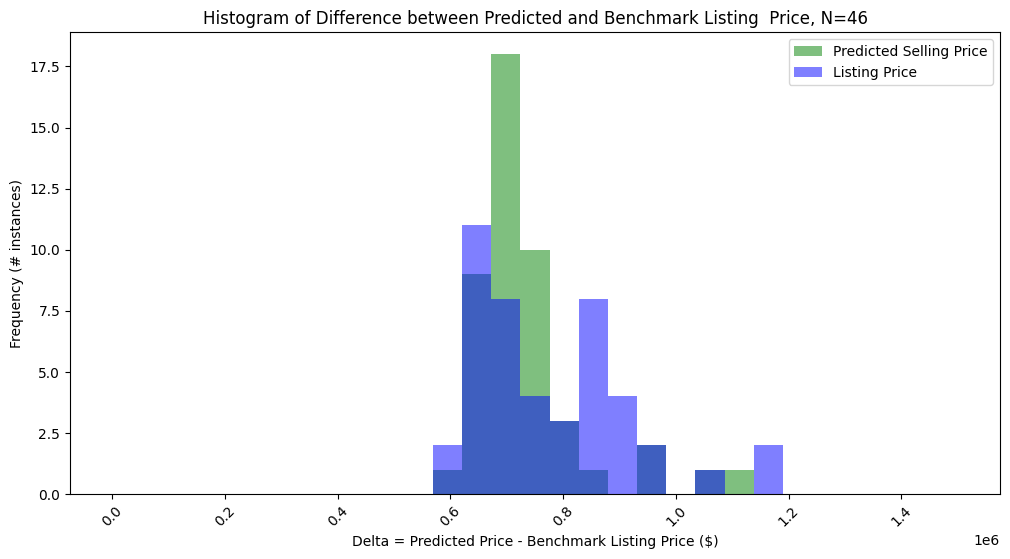

In [171]:
plt.figure(figsize=(12,6))
bins = np.linspace(0, 1.5*10**6, num=30)
plt.hist(preda_custom, bins=bins, label='Predicted Selling Price',edgecolor='None', alpha = 0.5, color= 'g')
plt.hist(red_active.y, bins=bins, label='Listing Price',edgecolor='None', alpha = 0.5, color= 'b')
plt.title("Histogram of Difference between Predicted and Benchmark Listing  Price, N=%d" % len(preda_custom))
plt.xlabel('Delta = Predicted Price - Benchmark Listing Price ($)')
plt.ylabel('Frequency (# instances)')
plt.legend(loc='upper right')
# plt.xlim(-500, 500)
xt = plt.xticks(rotation=45)
print("Note that predicted price is not trying to match the Listing price")
print("The predicted price is meant to be an objective measure of the property's value based on its column characteristics")

In [172]:
active_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 1 to 77
Data columns (total 27 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    46 non-null     object 
 1   SOLD DATE                                                                                    0 non-null      float64
 2   PROPERTY TYPE                                                                                46 non-null     object 
 3   ADDRESS                                                                                      46 non-null     object 
 4   CITY                                                                                         46 non-null     object 
 5   STATE OR PROVINCE                     

In [181]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# target_col = 'Pred'
target_col = 'Pred Custom'
delta_col = f"Delta {target_col}"


active_data['Delta Pred'] = preda_lin - red_active.y
active_data['Delta Pred Custom'] = preda_custom - red_active.y

active_data['Pred'] = preda_lin
active_data['Pred Custom'] = preda_custom

ASC=0

sorted_active = active_data.sort_values(by=delta_col, ascending=ASC)
print('Null pred: %s' % (active_data[delta_col].isnull().count()))
N = 50
# print_rows(sorted_active, 0, N)
print('ACTIVE LISTINGS\n====\n')
# sorted_active = sorted_active[sorted_active['PROPERTY TYPE'] != 'Condo/Co-op']

target_slice = sorted_active[:N]
print(target_slice.shape)
target_slice[INTEREST_COLS + [target_col, delta_col, 'Delta Pred']]

# Note could add zip/state to the table below.

Null pred: 46
ACTIVE LISTINGS
====

(46, 32)


,ADDRESS,CITY,LOT SIZE,SQUARE FEET,BEDS,PRICE,Pred Custom,Delta Pred Custom,Delta Pred
14,31 Shea's Dr,Auburn,"87,555.00",3650,4,815900,"1,069,100.88","253,200.88","-4,139.59"
63,282 Shaker Rd,Concord,"42,688.00",2544,3,619900,"732,688.44","112,788.44","24,329.46"
70,14 Eagle Perch Dr Lot 14,Boscawen,"30,709.00",1975,3,649900,"722,915.44","73,015.44","81,458.41"
62,268 N Main St,Concord,"7,405.00",3336,4,624900,"688,264.00","63,364.00","111,032.92"
43,10 Midmark Ln,Concord,"31,363.00",2444,3,654000,"706,225.19","52,225.19","54,995.62"
71,8 Midmark Ln,Concord,"35,719.00",1725,3,615000,"663,511.06","48,511.06","116,358.41"
49,15 Evelyn St,Hooksett,"100,623.00",2814,4,684900,"732,652.81","47,752.81","83,724.91"
47,423 Blane Cir #5,Pembroke,NaN,2083,3,649900,"690,449.81","40,549.81","-3,795.42"
69,5 Eagle Perch Dr Lot 5,Boscawen,"30,056.00",2188,4,625000,"661,863.31","36,863.31","54,040.82"
51,242 Eve St,Manchester,"21,780.00",3837,4,679000,"712,012.00","33,012.00","117,024.78"


In [174]:
# active_data['Delta Pred'].describe()
(active_data[delta_col]).isnull().any()

False

In [175]:
# sorted_active[sorted_active['PRICE'] == 499000]
print(sorted_active.shape)
print(sorted_active.columns.values)


(46, 31)
['SALE TYPE' 'SOLD DATE' 'PROPERTY TYPE' 'ADDRESS' 'CITY'
 'STATE OR PROVINCE' 'ZIP OR POSTAL CODE' 'PRICE' 'BEDS' 'BATHS'
 'LOCATION' 'SQUARE FEET' 'LOT SIZE' 'YEAR BUILT' 'DAYS ON MARKET'
 '$/SQUARE FEET' 'HOA/MONTH' 'STATUS' 'NEXT OPEN HOUSE START TIME'
 'NEXT OPEN HOUSE END TIME'
 'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)'
 'SOURCE' 'MLS#' 'FAVORITE' 'INTERESTED' 'LATITUDE' 'LONGITUDE'
 'Delta Pred' 'Delta Pred Custom' 'Pred' 'Pred Custom']


In [176]:
num_rows = len(sorted_active)
sorted_active[-10:]
# print_rows(sorted_active, num_rows-10, num_rows)

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,Delta Pred,Delta Pred Custom,Pred,Pred Custom
77,MLS Listing,NaN,Single Family Residential,S 40 BOW DUNBARTON Rd Lot 40,Bow,NH,03304,899900,4,2.50,...,PrimeMLS,4922075,N,Y,43.08,-71.52,543.44,"-129,531.81","900,443.44","770,368.19"
60,MLS Listing,NaN,Single Family Residential,277 Hedgerose Ln,Hopkinton,NH,03229,899000,3,3.50,...,PrimeMLS,4951542,N,Y,43.18,-71.62,"-79,763.80","-144,743.00","819,236.20","754,257.00"
6,MLS Listing,NaN,Single Family Residential,82 I Sawmill Rd,Bow,NH,03304,899900,4,2.50,...,PrimeMLS,4962128,N,Y,43.14,-71.55,"35,924.06","-151,678.44","935,824.06","748,221.56"
26,MLS Listing,NaN,Single Family Residential,20 Garden Song Dr,Hooksett,NH,03106,829500,3,2.50,...,PrimeMLS,4961094,N,Y,43.04,-71.39,"-50,103.66","-155,716.25","779,396.34","673,783.75"
72,MLS Listing,NaN,Single Family Residential,33 Quimby Rd,Bow,NH,03304,874900,3,2.50,...,PrimeMLS,4936585,N,Y,43.08,-71.51,"-187,431.29","-160,227.69","687,468.71","714,672.31"
1,MLS Listing,NaN,Single Family Residential,82J Sawmill Rd,Bow,NH,03304,969900,4,3.50,...,PrimeMLS,4962289,N,Y,43.14,-71.55,"-27,287.71","-168,513.50","942,612.29","801,386.50"
46,MLS Listing,NaN,Single Family Residential,308 Montelona Rd,Goffstown,NH,03045,849900,4,2.50,...,PrimeMLS,4958204,N,Y,43.06,-71.55,"-58,251.67","-186,210.69","791,648.33","663,689.31"
74,MLS Listing,NaN,Single Family Residential,40 D Quimby Rd,Bow,NH,03304,1050000,4,2.50,...,PrimeMLS,4929190,N,Y,43.08,-71.51,"-149,556.56","-342,282.44","900,443.44","707,717.56"
75,MLS Listing,NaN,Single Family Residential,40-C Quimby Rd Lot 40-C,Bow,NH,03304,1175000,4,3.50,...,PrimeMLS,4929161,N,Y,43.08,-71.51,"-210,323.39","-370,686.31","964,676.61","804,313.69"
65,MLS Listing,NaN,Single Family Residential,845 Upper Straw Rd,Hopkinton,NH,03229,1795000,4,4.50,...,PrimeMLS,4946584,N,Y,43.18,-71.63,"-842,709.00","-837,192.81","952,291.00","957,807.19"


In [177]:
# sorted_active.iloc[num_rows-1]
# print(sorted_active.columns.values)
sorted_active[sorted_active['PROPERTY TYPE'] == 'Multi-Family (2-4 Unit)']

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,Delta Pred,Delta Pred Custom,Pred,Pred Custom


In [178]:
active_data['PSQFT'] = active_data['PRICE']/active_data['SQUARE FEET']


In [179]:
train['PSQFT'] = train['PRICE']/train['SQUARE FEET']
train.groupby(['CITY'])['PSQFT'].count()
# x_box = 'CITY'
# y_box = 'PSQFT'
# sns.boxplot(x = x_box, y = y_box,  data = train)
# plt.title("Average property %s distribution by %s" % (y_box, x_box))
# xt = plt.xticks(rotation=45)
# active_data.columns.values
# active_data['CITY']

CITY
Auburn          2
Bedford         3
Boscawen        1
Bow            12
Concord         9
Dunbarton       2
Goffstown       3
Hooksett       15
Hopkinton       1
Londonderry     1
Manchester     22
Pembroke        4
Name: PSQFT, dtype: int64

In [180]:
result_csv = sorted_active[["PROPERTY TYPE", "BEDS", "BATHS", "ADDRESS", "CITY", "LOCATION", "SQUARE FEET", "PRICE", delta_col]]
result_csv['Predicted Price'] = result_csv['PRICE'] + result_csv[delta_col]
result_csv = result_csv.round(2)
result_csv.to_csv('./redfin/redfin_results.csv')
print(result_csv.shape)

(46, 10)


/var/folders/08/3gvkyj816j39hpywkn6fwnx80000gq/T/ipykernel_53012/693026687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_csv['Predicted Price'] = result_csv['PRICE'] + result_csv[delta_col]
